In [ ]:
from google.colab import drive # Mount the google drive for data loading
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import required libraries

In [ ]:
import numpy as np #helps for array operation
import pandas as pd #helps to read the data
import matplotlib.pyplot as plt #helps with graphical plots
from sklearn.preprocessing import MinMaxScaler #helps for standardation of input data
import keras #helps for CNN model construction
import tensorflow as tf #helps for CNN model construction
import math #helps with calculating evaluation metrics
import sklearn.metrics #helps with calculating evaluation metrics

## Import data
We are using the same training and testing split in all models to offer better comparison, so they are imported individually and then I merge them to check everything is as expected.

EDA was done in a separate file, so only basic checks are required to ensure data has imported correctly and looks like it should.

In [ ]:
movies_test = pd.read_csv('/content/drive/MyDrive/data/testing_movies.csv')  # Load data with the corresponding path in google drive
movies_train = pd.read_csv('/content/drive/MyDrive/data/training_movies.csv')  # Load data with the corresponding path in google drive

movies_df = pd.concat([movies_test, movies_train])

In [ ]:
print (movies_test.columns) # Columns names
print (movies_train.columns) # Columns names
print (movies_df.columns) # Columns names

# Check they are the same for both sets

Index(['Title', 'Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')
Index(['Title', 'Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')
Index(['Title', 'Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')


In [ ]:
movies_df = movies_df.drop(['Title'], axis=1)
movies_test = movies_test.drop(['Title'], axis=1)
movies_train = movies_train.drop(['Title'], axis=1)

print (movies_test.columns) # Columns names
print (movies_train.columns) # Columns names
print (movies_df.columns) # Columns names

Index(['Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')
Index(['Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')
Index(['Duration', 'Budget', 'Reviews_by_Users', 'IMDB_Score',
       'Gross_Earnings'],
      dtype='object')


In [ ]:
print (movies_test.shape)   # Size of test dataset
print (movies_train.shape)   # Size of train dataset

print (movies_df.shape) # Size of total dataset

(563, 5)
(1311, 5)
(1874, 5)


In [ ]:
print (movies_train.head())  # Display of the first few samples

   Duration    Budget  Reviews_by_Users  IMDB_Score  Gross_Earnings
0        86   2800000                53         6.0          475000
1       103  50000000                26         6.9          206400
2       109  30000000               221         6.1        10965209
3       124  75000000               379         5.9        68473360
4       104  55000000               279         6.6        25040293


In [ ]:
print (movies_df.info())  # Infomation of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 1874 entries, 0 to 1310
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Duration          1874 non-null   int64  
 1   Budget            1874 non-null   int64  
 2   Reviews_by_Users  1874 non-null   int64  
 3   IMDB_Score        1874 non-null   float64
 4   Gross_Earnings    1874 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 87.8 KB
None


## Checking the training / test split looks well balanced

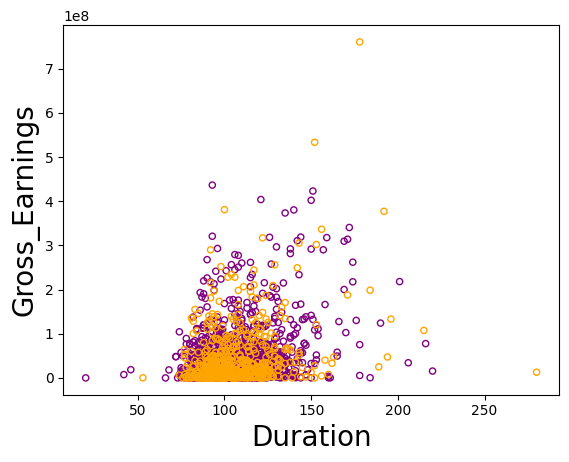

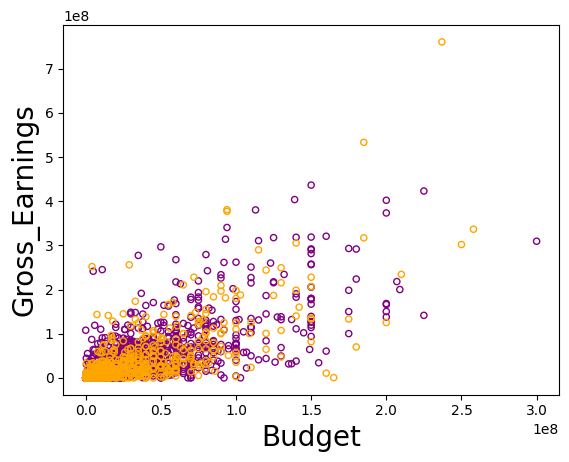

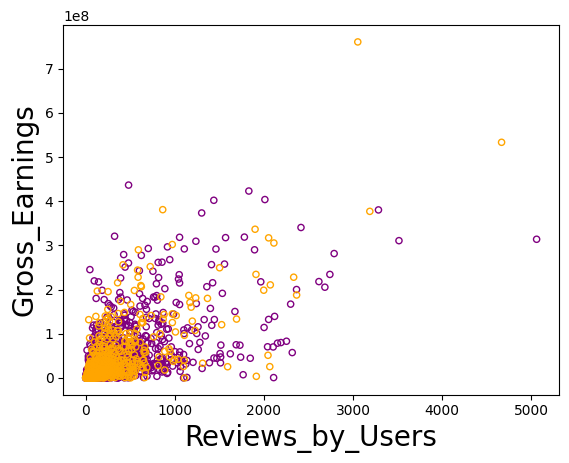

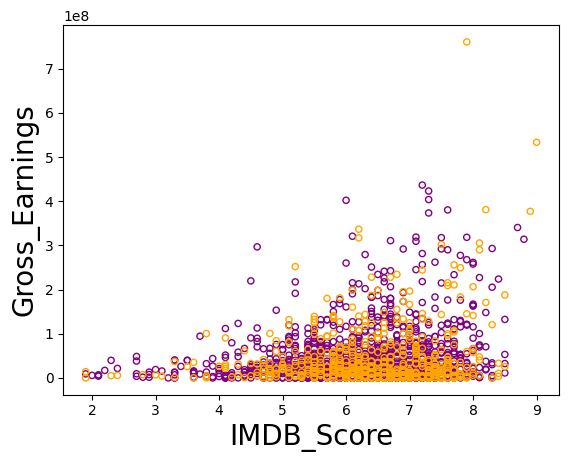

In [ ]:
# Visualization
for column in movies_df.columns[:-1]:
  # plt.scatter(movies_df[column], movies_df['Gross_Earnings'], s=20, marker='o', edgecolor=['blue'], c='none')  # Scatter saleprice verus each feature
  plt.scatter(movies_train[column], movies_train['Gross_Earnings'], s=20, marker='o', edgecolor=['purple'], c='none')  # train
  plt.scatter(movies_test[column], movies_test['Gross_Earnings'], s=20, marker='o', edgecolor=['orange'], c='none')  # test
  plt.xlabel(column, fontsize=20)
  plt.ylabel('Gross_Earnings', fontsize=20)
  plt.show()

## Normalisation
We decided as a group to use Min-Max scaling for all models

In [ ]:
# Using the Min Max Scaler to match how we did the other models
scaler = MinMaxScaler()

# Standardisation fitting using training data
scaler.fit(movies_train)

movies_train_scaled = scaler.transform(movies_train)
# adding the column names back in and turning it back into a pandas df
movies_train_scaled = pd.DataFrame(movies_train_scaled, columns=list(movies_train.columns))

movies_test_scaled = scaler.transform(movies_test)
# adding the column names back in and turning it back into a pandas df
movies_test_scaled = pd.DataFrame(movies_test_scaled, columns=list(movies_test.columns))

## Reshaping the data in preparation for the CNN

In [ ]:
# Transform input data to an array
X_train = movies_train_scaled.iloc[:,:-1].values
Y_train = movies_train_scaled['Gross_Earnings'].values.reshape(-1,1)

# Transform input data to an array
X_test = movies_test_scaled.iloc[:,:-1].values
Y_test = movies_test_scaled['Gross_Earnings'].values.reshape(-1,1)

In [ ]:
# Add a dimension for each training sample - 4 x 1
X_train = np.expand_dims(X_train, axis=2)

# Add a dimension for each training sample to form an 'image' as the data is actually 1D - 4 x 1 x 1
X_train = np.expand_dims(X_train, axis=2)

# Add a dimension for each testing sample - 4 x 1
X_test = np.expand_dims(X_test, axis=2)

# Add a dimension for each testing sample to form an 'image' as the data is actually 1D - 4 x 1 x 1
X_test = np.expand_dims(X_test, axis=2)

In [ ]:
# Check data is in correct shape for the model
print (X_train.shape)
print (X_test.shape)

(1311, 4, 1, 1)
(563, 4, 1, 1)


## Building and running the model

In [ ]:
# LeNet-5 structure for model training
model = keras.Sequential()

# The first convolutional layer. Input shape is 4x1x1
# Activation function is Rectified Linear Unit (ReLU) as we're looking for a numerical output (regression) with a value greater than 0
# Kernel size and stride are set as (2,1) and (1,1), respectively.
# The number of convolutional kernels is 3, fewer than the number of parameters.
# Padding is 'same' so the output shape is the same as the input shape.
model.add(keras.layers.Conv2D(filters=3, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu', input_shape=(4, 1, 1)))

# Pooling not required as size is not large enough to be a problem.

# # The second convolutional layer. The output shape is 4x1x16, where 4 = 4/1.
model.add(keras.layers.Conv2D(filters=10, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))

# # The previous output is flattened to be a vector.
model.add(keras.layers.Flatten())

# # The first fully connected layer.
model.add(keras.layers.Dense(120, activation='relu'))

# # The second fully connected layer.
model.add(keras.layers.Dense(84, activation='relu'))

# we have 1 neuron for output (Gross Earnings).
model.add(keras.layers.Dense(1))

# Summary the constructed model.
model.summary()

# Model construction with a SGD optimizer and a mean squared error loss function.
model.compile(tf.keras.optimizers.SGD(), 'mean_squared_error')

# Model training with some hyperparameters.
model.fit(X_train, Y_train, epochs = 100, batch_size = 64, verbose = 2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 4, 1, 3)           9         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 1, 10)          70        
                                                                 
 flatten_3 (Flatten)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 120)               4920      
                                                                 
 dense_10 (Dense)            (None, 84)                10164     
                                                                 
 dense_11 (Dense)            (None, 1)                 85        
                                                                 
Total params: 15248 (59.56 KB)
Trainable params: 15248

## Evaluating the model

18/18 [==============================] - 0s 2ms/step


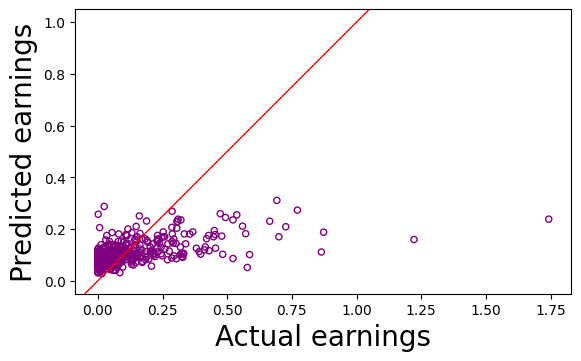

In [ ]:
prediction = model.predict(X_test)    # Prediction of the testing set

# Visualization
# plt.scatter(Y_test*Y_train_max, prediction*Y_train_max, s=20, marker='o', edgecolor=['purple'], c='none')
plt.scatter(Y_test, prediction, s=20, marker='o', edgecolor=['purple'], c='none')
plt.xlabel('Actual earnings', fontsize=20)
plt.ylabel('Predicted earnings', fontsize=20)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.axline((0, 0), (1, 1), linewidth=1, color='r')

plt.show()

In [ ]:
# Calculate the RMSE
mse = sklearn.metrics.mean_squared_error(Y_test, prediction)
rmse = math.sqrt(mse)
print(f'RMSE: {rmse}')

# Calculate the r2
r2 = sklearn.metrics.r2_score(Y_test, prediction)
print(f'R2: {r2}')

RMSE: 0.14087711848921927
R2: 0.23262606642217643
